In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
# tf.keras.utils.text_dataset_from_directory
tf.keras.utils.image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [2]:
import os

# Create a new folder called "augmented_images"
if not os.path.exists('augmented_images'):
    os.makedirs('augmented_images')


In [3]:
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

# Define the augmentation parameters
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

# Loop through each image in the dataset
# for filename in os.listdir('/kaggle/input/facial-expression-dataset/train/train/'):
    # Open the image file


path_to_directory = "/kaggle/input/face-expression-recognition-dataset/images/train/"

# Get a list of all image files in the directory
image_files = [os.path.join(path_to_directory, file) for file in os.listdir(path_to_directory) if file.endswith('.jpg')]

# Iterate through the list and open each image file
for file in image_files:
    img = Image.open(file)
    # do something with the image file here
    
#     img = Image.open(os.path.join('/kaggle/input/facial-expression-dataset/train/train/', filename))

    # Convert the image to a numpy array
    x = np.array(img)

    # Reshape the numpy array to have a batch dimension
    x = x.reshape((1,) + x.shape)

    # Generate augmented images and save them to the new folder
    i = 0
    for batch in datagen.flow(x, batch_size=1, save_to_dir='augmented_images', save_prefix='aug_', save_format='jpg'):
        i += 1
        if i > 4:  # Generate 4 augmented images per original image
            break


In [4]:
# /kaggle/input/facial-expression-dataset/train/train

# !pip install detectron2==0.1.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html


TRAIN_DIR = '/kaggle/working/augmented_images/'
TEST_DIR = '/kaggle/input/face-expression-recognition-dataset/images/validation/'

In [5]:

def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels

In [6]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset("/kaggle/input/face-expression-recognition-dataset/images/train/")
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


image    label
0  /kaggle/input/face-expression-recognition-data...  neutral
1  /kaggle/input/face-expression-recognition-data...    angry
2  /kaggle/input/face-expression-recognition-data...  disgust
3  /kaggle/input/face-expression-recognition-data...    angry
4  /kaggle/input/face-expression-recognition-data...  neutral

In [7]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


image     label
0  /kaggle/input/face-expression-recognition-data...  surprise
1  /kaggle/input/face-expression-recognition-data...  surprise
2  /kaggle/input/face-expression-recognition-data...  surprise
3  /kaggle/input/face-expression-recognition-data...  surprise
4  /kaggle/input/face-expression-recognition-data...  surprise

In [8]:
# train_features = extract_features(train['image'])

In [9]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [10]:
train_features = extract_features(train['image'])
test_features = extract_features(test['image'])

  0%|          | 0/28821 [00:00<?, ?it/s]

  0%|          | 0/7066 [00:00<?, ?it/s]

In [11]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [12]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [13]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [14]:
y_train[0]

array([0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [15]:
# config
input_shape = (48, 48, 1)
output_class = 7


In [17]:
# from tensorflow.keras.optimizers import Adam

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
)
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

from keras.optimizers import Adam,SGD,RMSprop
# import tensorflow as tf

# # Define a ReLU activation layer
# relu = tf.keras.layers.ReLU()
from keras.models import Sequential
from keras.layers import Dense, Activation
no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))



opt = Adam(lr = 0.00015)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

#   return model

In [19]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=65, validation_data=(x_test, y_test))

Epoch 1/65


2023-08-20 02:35:34.912970: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


226/226 [==============================] - 25s 66ms/step - loss: 2.0050 - accuracy: 0.2304 - val_loss: 1.8799 - val_accuracy: 0.1609
Epoch 2/65
226/226 [==============================] - 14s 62ms/step - loss: 1.8216 - accuracy: 0.2908 - val_loss: 1.8408 - val_accuracy: 0.2993
Epoch 3/65
226/226 [==============================] - 14s 63ms/step - loss: 1.7147 - accuracy: 0.3401 - val_loss: 1.8060 - val_accuracy: 0.3235
Epoch 4/65
226/226 [==============================] - 14s 63ms/step - loss: 1.6257 - accuracy: 0.3699 - val_loss: 1.7518 - val_accuracy: 0.3759
Epoch 5/65
226/226 [==============================] - 14s 63ms/step - loss: 1.5584 - accuracy: 0.3953 - val_loss: 1.6668 - val_accuracy: 0.3998
Epoch 6/65
226/226 [==============================] - 14s 62ms/step - loss: 1.4966 - accuracy: 0.4210 - val_loss: 1.3761 - val_accuracy: 0.4718
Epoch 7/65
226/226 [==============================] - 15s 65ms/step - loss: 1.4343 - accuracy: 0.4516 - val_loss: 1.3606 - val_accuracy: 0.4720
Epo

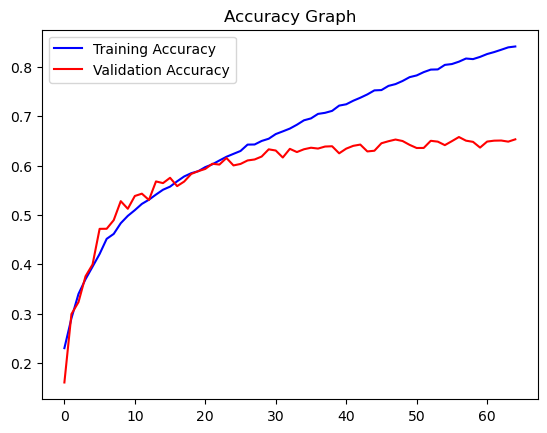

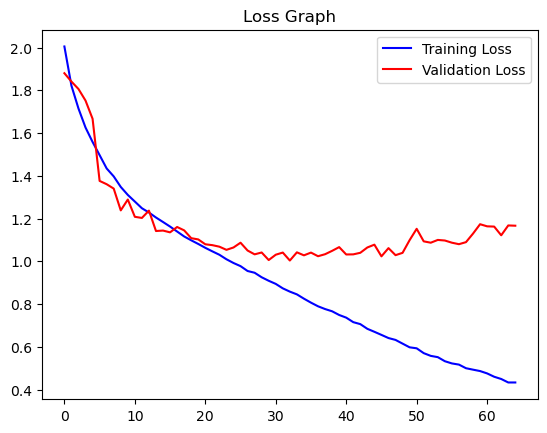

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

In [21]:
audio_mapping = {
    'happy': '/kaggle/input/audiofiles/Deva Deva(PagalWorld.com.se).mp3',
    'sad': '/kaggle/input/audiofiles/Rihanna-Lift-Me-Up-Wakanda-Forever.mp3',
    'angry': '/kaggle/input/audiofiles/Lost Control.mp3',
    'surprise':'/kaggle/input/audiofiles/Shivoham - Adipurush 128 Kbps.mp3',
    'fear':'/kaggle/input/audiofiles/Kaalbhairav Ashtakam Agam Aggarwal(StarSong.In).mp3',
    'neutral':'/kaggle/input/audiofiles/Hold-My-Hand(PaglaSongs).mp3',
    'disgust':'/kaggle/input/audiofiles/Darshana (Hridayam)(audiosong.in).mp3'
    
    # Add more labels and their corresponding audio paths
}


Original Output: neutral
1/1 [==============================] - 0s 20ms/step
Predicted Output: neutral


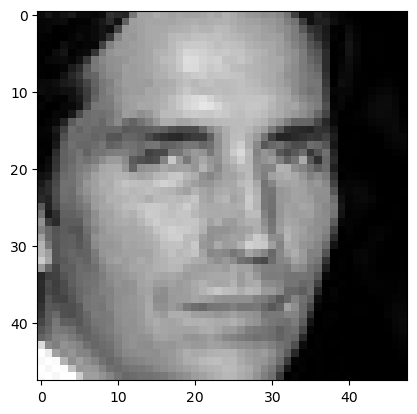

In [59]:
# Preprocess the input image if necessary (e.g., resizing, converting to grayscale)
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))

# # Use the model to make predictions on the input image
# pred = model.predict(input_image.reshape(1, 48, 48, 1))

# Convert the prediction to a human-readable label
prediction_label = le.inverse_transform([pred.argmax()])[0]

# Print the predicted output
print("Predicted Output:", prediction_label)


# Display the input image
# plt.imshow(input_image.reshape(48, 48), cmap='gray')
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray')

plt.show()


In [60]:
audio_mapping = {
    'happy': '/kaggle/input/audiofiles/Deva Deva(PagalWorld.com.se).mp3',
    'sad': '/kaggle/input/audiofiles/Rihanna-Lift-Me-Up-Wakanda-Forever.mp3',
    'angry': '/kaggle/input/audiofiles/Lost Control.mp3',
    'surprise':'/kaggle/input/audiofiles/Shivoham - Adipurush 128 Kbps.mp3',
    'fear':'/kaggle/input/audiofiles/Kaalbhairav Ashtakam Agam Aggarwal(StarSong.In).mp3',
    'neutral':'/kaggle/input/audiofiles/Hold-My-Hand(PaglaSongs).mp3',
    'disgust':'/kaggle/input/audiofiles/Darshana (Hridayam)(audiosong.in).mp3'
}
    # Add more labels and their corresponding audio paths


predicted_audio_path = audio_mapping.get(prediction_label)

DATA ARGUMENTATION

In [61]:
! pip install pydub

from pydub import AudioSegment
import IPython

# We will listen to this file:
# 213_1p5_Pr_mc_AKGC417L.wav

audio_file = predicted_audio_path 

# path = \
# '/kaggle/input/audiofiles/Kaalbhairav Ashtakam Agam Aggarwal(StarSong.In).mp3' + audio_file

IPython.display.Audio(audio_file)

